## Setup and Library Imports for Image Classification Using CNN in TensorFlow/Keras

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import os
import matplotlib.pyplot as plt
import warnings
from tqdm.auto import tqdm
warnings.filterwarnings("ignore")
%matplotlib inline
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from keras.preprocessing.image import load_img, img_to_array
from keras.models import Sequential
from keras.layers import Dense,Conv2D,Dropout,Flatten,MaxPooling2D

## Load dataset

In [ ]:
TRAIN_DIR="/content/train/"
TEST_DIR="/content/test/"


## PreProcessing

 ### Loading Image Paths and Corresponding Labels

In [ ]:
def load_dataset(directory):
    image_paths = []
    labels = []

    for label in os.listdir(directory):
        label_path = os.path.join(directory, label)
        if not os.path.isdir(label_path):
            continue  # skip files like .DS_Store

        for filename in os.listdir(label_path):
            image_path = os.path.join(label_path, filename)
            image_paths.append(image_path)
            labels.append(label)

    return image_paths, labels

### Create and Shuffle Training DataFrame

In [ ]:
# Convert into DataFrame
train = pd.DataFrame()  # Initialize an empty DataFrame
train['image'], train['label'] = load_dataset(TRAIN_DIR)

# Shuffle the dataset
train = train.sample(frac=1).reset_index(drop=True)
train.head()

,image,label
0,/content/train/happy/Training_39266848.jpg,happy
1,/content/train/happy/Training_77721822.jpg,happy
2,/content/train/happy/Training_42354594.jpg,happy
3,/content/train/neutral/Training_2737636.jpg,neutral
4,/content/train/angry/Training_17026096.jpg,angry


In [ ]:
# Convert into DataFrame
test = pd.DataFrame()  # Initialize an empty DataFrame
test['image'], test['label'] = load_dataset(TEST_DIR)

test.head()

,image,label
0,/content/test/happy/PublicTest_55888619.jpg,happy
1,/content/test/happy/PublicTest_74227592.jpg,happy
2,/content/test/happy/PrivateTest_25427646.jpg,happy
3,/content/test/happy/PublicTest_29065605.jpg,happy
4,/content/test/happy/PrivateTest_34104108.jpg,happy


## Exploratory Data Analysis (EDA) on Training Set

Text(0.5, 1.0, 'Distribution of training data')

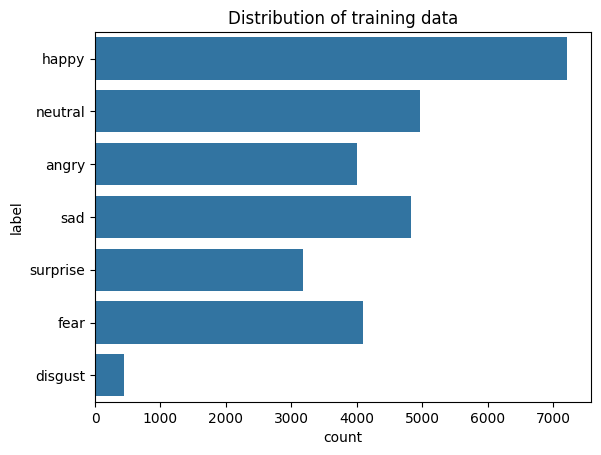

In [ ]:
sns.countplot(train['label'])
plt.title("Distribution of training data")

### Image Augmentation for Class Balancing

In [ ]:
from torchvision import transforms
from PIL import Image
import os

augment = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.3, contrast=0.3),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0))
])

augmented_data = []
output_dir = "/content/train/disgust"

os.makedirs(output_dir, exist_ok=True)

for idx, row in disgust_df.iterrows():
    img_path = row['image']
    label = row['label']

    img = Image.open(img_path).convert("RGB")

    for i in range(5):  # Create 5 augmentations per image
        aug_img = augment(img)
        aug_path = os.path.join(output_dir, f"aug_{idx}_{i}.jpg")
        aug_img.save(aug_path)
        augmented_data.append({'image': aug_path, 'label': label})

augmented_df = pd.DataFrame(augmented_data)
train = pd.concat([train, augmented_df], ignore_index=True)

### Display Example Image from Training Set

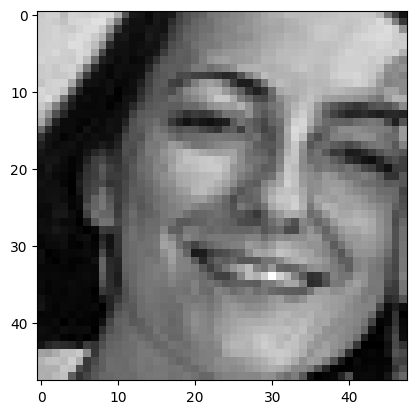

In [ ]:
from PIL import Image
img = Image.open(train['image'][0])
plt.imshow(img,cmap='gray')

### Display Grid of Sample Images from Dataset

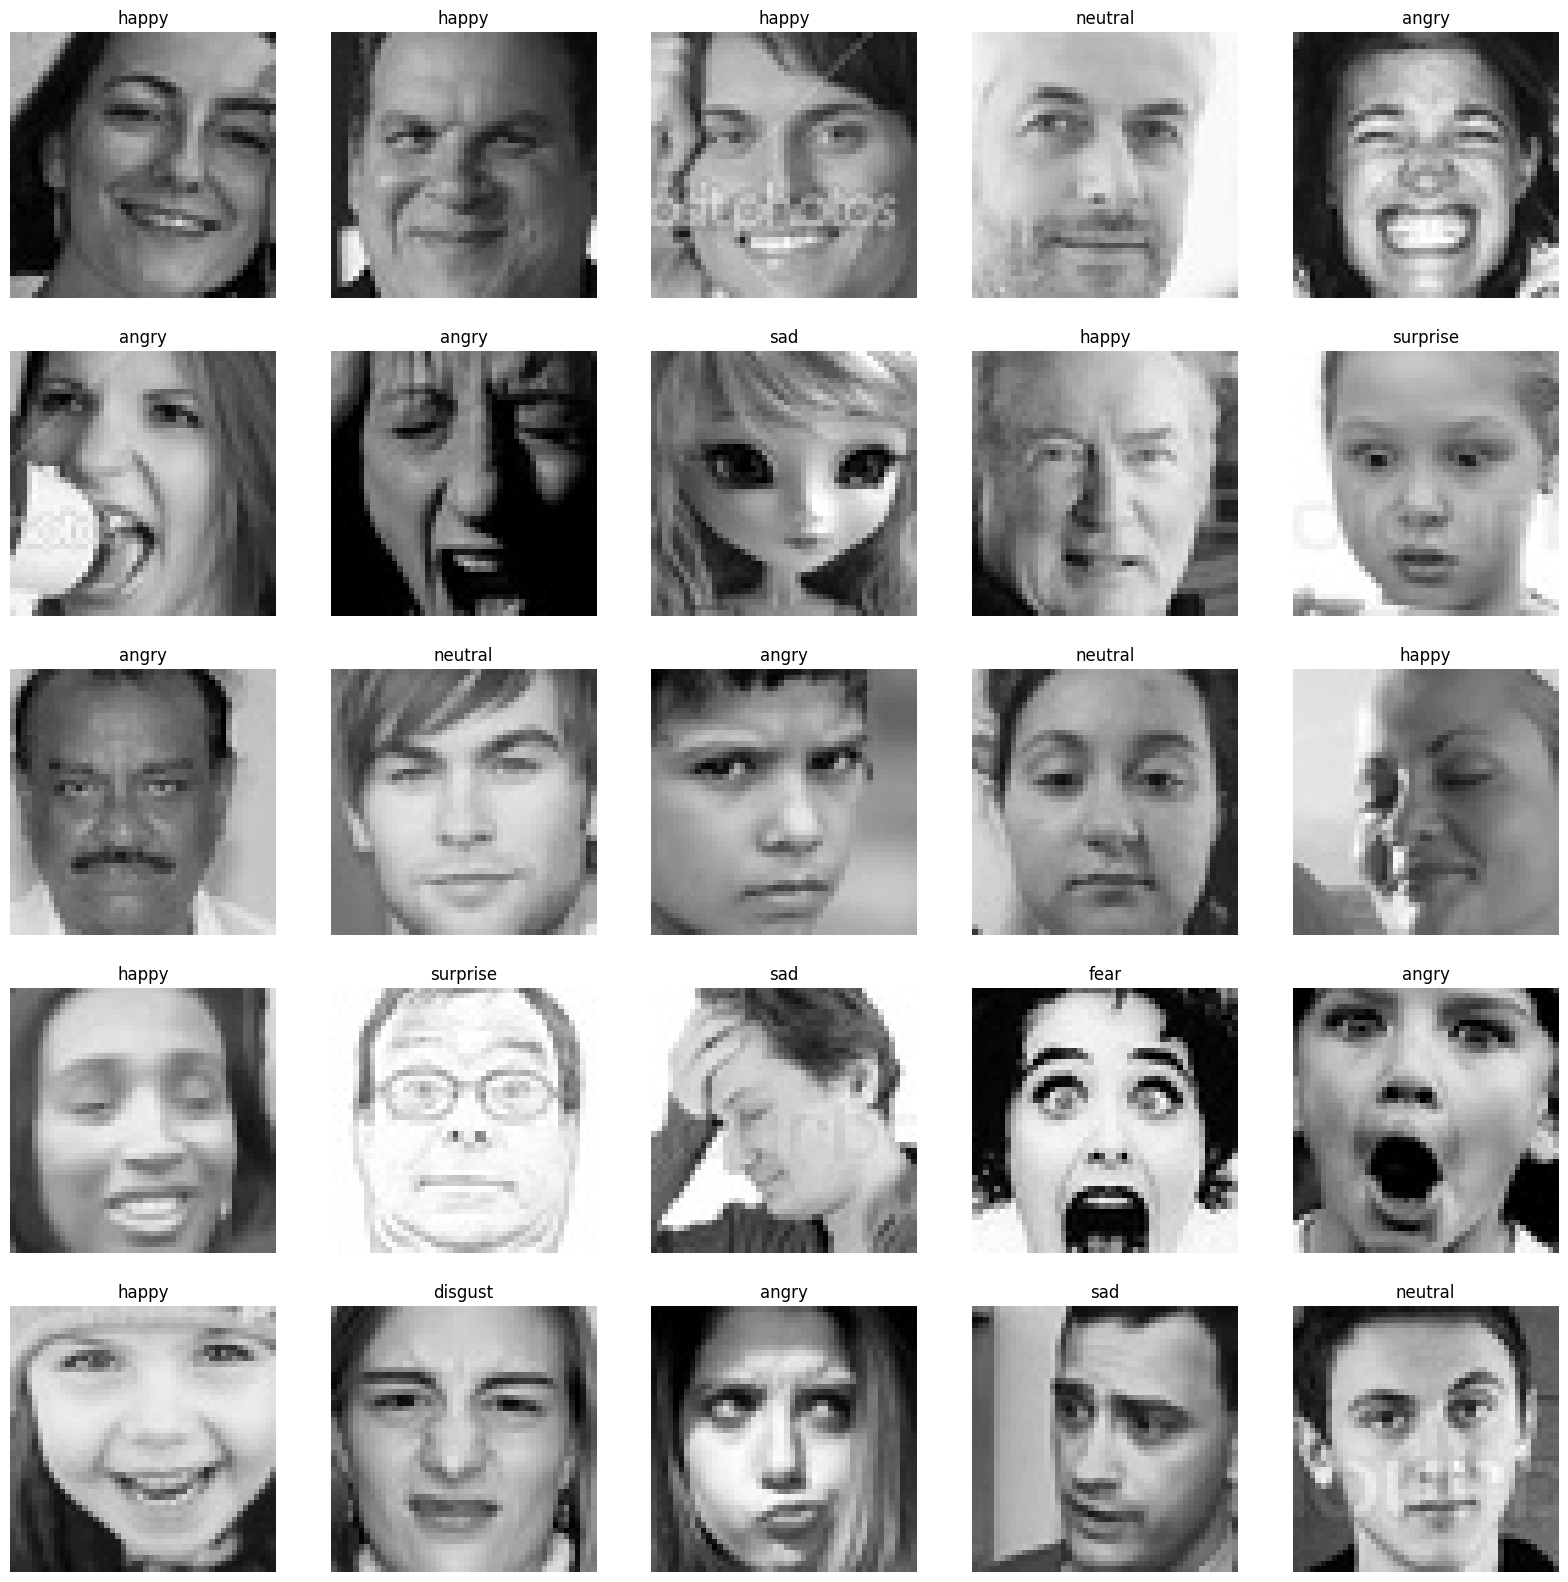

In [ ]:
# to display grid of images
plt.figure(figsize=(20, 20))
files = train.iloc[0:25]

# Corrected loop: use itertuples() and unpack correctly
for index, file, label in files.itertuples():
    plt.subplot(5, 5, index + 1)
    img = load_img(file)  # Assuming 'file' contains the file path
    img = np.array(img)  # Fixed typo: 'arrat' -> 'array'
    plt.imshow(img, cmap='gray')
    plt.title(label)
    plt.axis('off')

## Extract and Preprocess Image Features

In [ ]:
def extract_features(images):
    features = []
    for image in tqdm(images):
        img = load_img(image, color_mode='grayscale')
        img=np.array(img)
        features.append(img)
    features = np.array(features)
    features = features.reshape(len(features), 48, 48, 1)
    return features

In [ ]:
train_features = extract_features(train['image'])

  0%|          | 0/28709 [00:00<?, ?it/s]

In [ ]:
test_features = extract_features(test['image'])

  0%|          | 0/7178 [00:00<?, ?it/s]

## Normalize the image

In [ ]:
# normalize the image
x_train=train_features/255.0
x_test=test_features/255.0

In [ ]:
## convery label to integer
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
le.fit(train['label'])
y_train=le.transform(train['label'])
y_test=le.transform(test['label'])

In [ ]:
y_train=to_categorical(y_train, num_classes=7)
y_test=to_categorical(y_test, num_classes=7)

In [ ]:
y_train[0]

array([0., 0., 0., 1., 0., 0., 0.])

In [ ]:
#config
input_shape=(48,48,1)
output_class=7

## Build and Compile Convolutional Neural Network (CNN)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense

# Define the model
model = Sequential()

# --- Convolutional Block 1 ---
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.4))

# --- Convolutional Block 2 ---
model.add(Conv2D(256, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.4))

# --- Convolutional Block 3 ---
model.add(Conv2D(512, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.4))

# --- Convolutional Block 4 ---
model.add(Conv2D(512, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.4))

# --- Fully Connected Layers ---
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.4))

# --- Output Layer ---
model.add(Dense(output_class, activation='softmax'))

# Compile the model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
# traon the model

history=model.fit(x_train,y_train,epochs=100,batch_size=128,validation_data=(x_test,y_test))

Epoch 1/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 34s 97ms/step - accuracy: 0.2357 - loss: 1.8361 - val_accuracy: 0.2534 - val_loss: 1.8004
Epoch 2/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 20s 49ms/step - accuracy: 0.2539 - loss: 1.7886 - val_accuracy: 0.3064 - val_loss: 1.7009
Epoch 3/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 20s 48ms/step - accuracy: 0.3031 - loss: 1.6975 - val_accuracy: 0.4048 - val_loss: 1.5305
Epoch 4/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 20s 48ms/step - accuracy: 0.3856 - loss: 1.5770 - val_accuracy: 0.4411 - val_loss: 1.4236
Epoch 5/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 21s 49ms/step - accuracy: 0.4349 - loss: 1.4733 - val_accuracy: 0.4809 - val_loss: 1.3484
Epoch 6/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 11s 51ms/step - accuracy: 0.4559 - loss: 1.4152 - val_accuracy: 0.4996 - val_loss: 1.3020
Epoch 7/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 20s 50ms/step - accuracy: 0.4699 - loss: 1.3812 - val_accuracy: 0.4967 - val_loss: 1.2890
Epoch 8/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 20s 50ms/step - accuracy: 0.4911 - loss: 1

## RESULTS

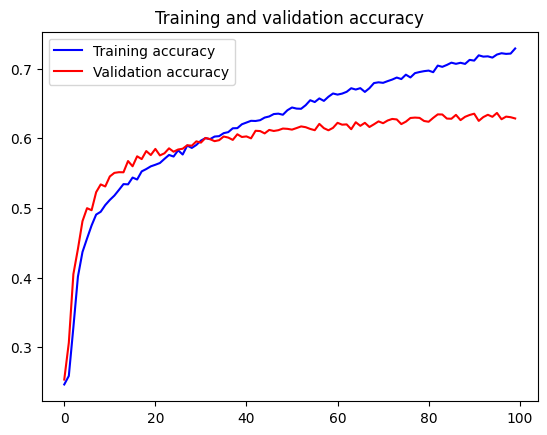

In [ ]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
epochs=range(len(acc))

plt.plot(epochs,acc,'b',label='Training accuracy')
plt.plot(epochs,val_acc,'r',label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()

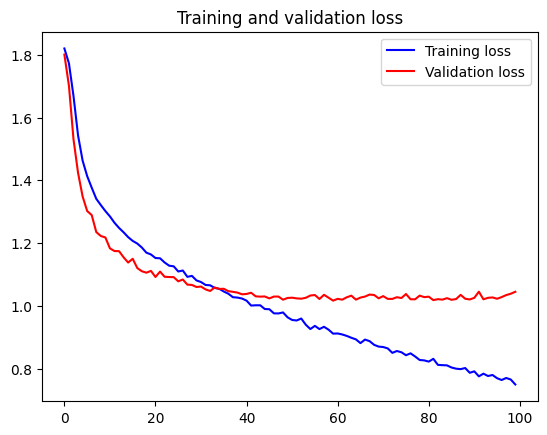

In [ ]:
loss=history.history['loss']
val_loss=history.history['val_loss']
plt.plot(epochs,loss,'b',label='Training loss')
plt.plot(epochs,val_loss,'r',label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

Original Output:  happy
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Predicted Output:  angry


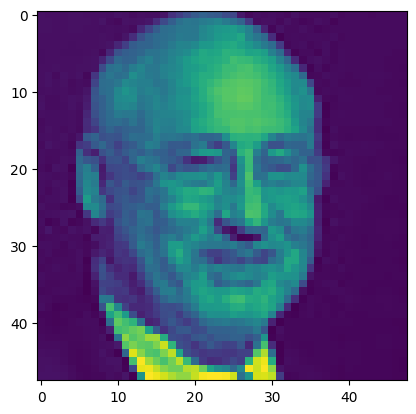

In [ ]:
import random

image_index=random.randint(0,len(test))
print("Original Output: ",test['label'][image_index])
pred=model.predict(x_test[image_index].reshape(1,48,48,1))
predicted_class=le.inverse_transform([np.argmax(pred)])
print("Predicted Output: ",predicted_class[0])
img = load_img(test['image'][image_index], color_mode='grayscale')
plt.imshow(img)

225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step


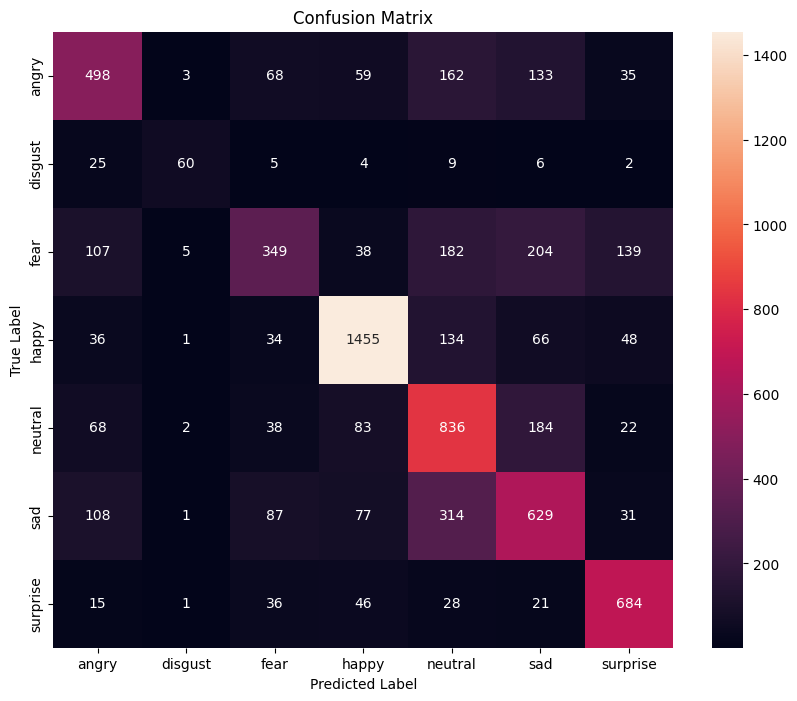

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Assuming you have your test data loaded as x_test and y_test

# 1. Load your saved model
from tensorflow.keras.models import load_model
model = load_model('/content/emotion_model.h5')  # Replace with your model path

# 2. Make predictions
y_pred = model.predict(x_test)

# 3. Convert predictions from probabilities to class labels
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# 4. Generate confusion matrix
confusion_mtx = confusion_matrix(y_true, y_pred_classes)

# 5. Plot the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(confusion_mtx, annot=True, fmt='d',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
from sklearn.metrics import classification_report

# Generate classification report
print("Classification Report:")
print(classification_report(y_true, y_pred_classes, target_names=le.classes_))

Classification Report:
              precision    recall  f1-score   support

       angry       0.58      0.52      0.55       958
     disgust       0.82      0.54      0.65       111
        fear       0.57      0.34      0.43      1024
       happy       0.83      0.82      0.82      1774
     neutral       0.50      0.68      0.58      1233
         sad       0.51      0.50      0.51      1247
    surprise       0.71      0.82      0.76       831

    accuracy                           0.63      7178
   macro avg       0.64      0.60      0.61      7178
weighted avg       0.63      0.63      0.62      7178



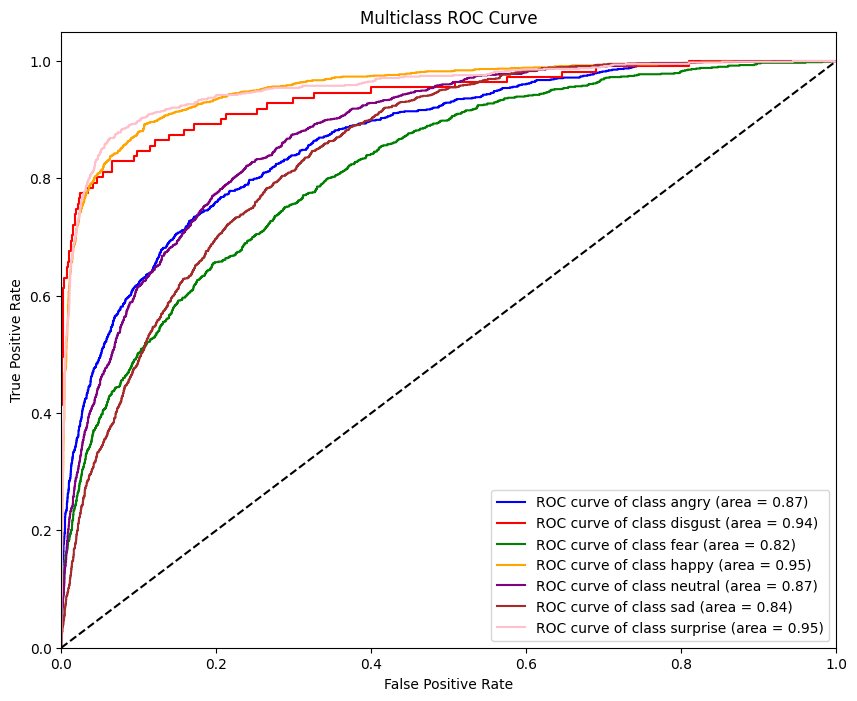

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

# Binarize the output for multiclass ROC
y_test_bin = label_binarize(y_true, classes=range(len(le.classes_)))
n_classes = y_test_bin.shape[1]

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize=(10, 8))
colors = ['blue', 'red', 'green', 'orange', 'purple', 'brown', 'pink']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(le.classes_[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC Curve')
plt.legend(loc="lower right")
plt.show()

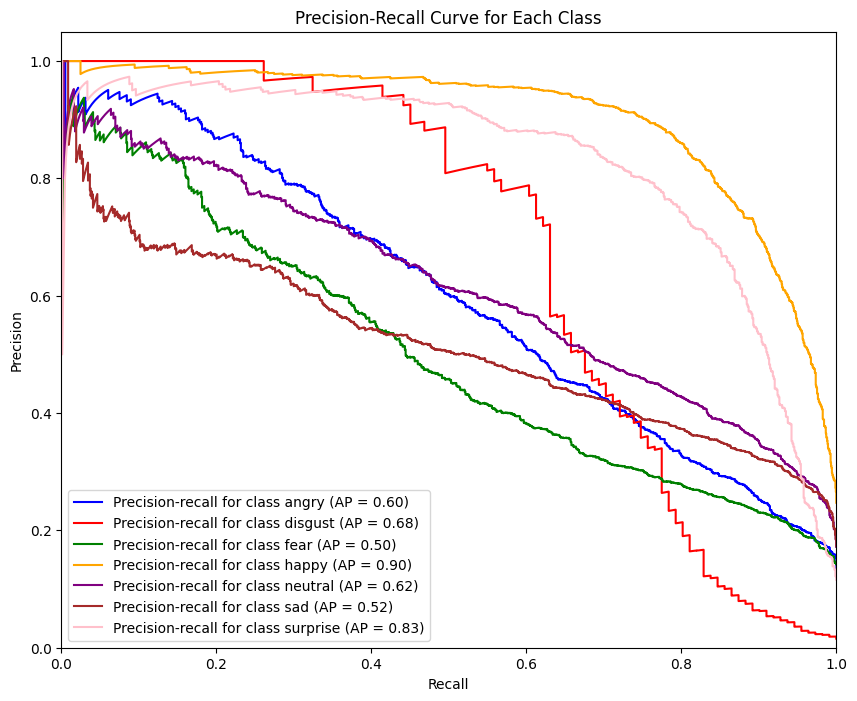


Additional Metrics:
Accuracy: 0.6284
Macro F1 Score: 0.6135
Weighted F1 Score: 0.6226
Cohen's Kappa: 0.5499


In [ ]:
from sklearn.metrics import precision_recall_curve, average_precision_score

# Precision-Recall Curve
precision = dict()
recall = dict()
average_precision = dict()

for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_test_bin[:, i], y_pred[:, i])
    average_precision[i] = average_precision_score(y_test_bin[:, i], y_pred[:, i])

# Plot Precision-Recall curve for each class
plt.figure(figsize=(10, 8))
for i, color in zip(range(n_classes), colors):
    plt.plot(recall[i], precision[i], color=color,
             label='Precision-recall for class {0} (AP = {1:0.2f})'
             ''.format(le.classes_[i], average_precision[i]))

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall Curve for Each Class')
plt.legend(loc="lower left")
plt.show()

# Calculate and display additional metrics
from sklearn.metrics import accuracy_score, f1_score, cohen_kappa_score

print("\nAdditional Metrics:")
print(f"Accuracy: {accuracy_score(y_true, y_pred_classes):.4f}")
print(f"Macro F1 Score: {f1_score(y_true, y_pred_classes, average='macro'):.4f}")
print(f"Weighted F1 Score: {f1_score(y_true, y_pred_classes, average='weighted'):.4f}")
print(f"Cohen's Kappa: {cohen_kappa_score(y_true, y_pred_classes):.4f}")

In [ ]:
import pandas as pd
from datetime import datetime

# Create a timestamp for the report
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

# Save classification report to CSV
report = classification_report(y_true, y_pred_classes, target_names=le.classes_, output_dict=True)
pd.DataFrame(report).transpose().to_csv(f'classification_report_{timestamp}.csv')

# Save metrics to text file
with open(f'model_metrics_{timestamp}.txt', 'w') as f:
    f.write("Model Evaluation Metrics\n")
    f.write("=======================\n\n")
    f.write(f"Evaluation Time: {timestamp}\n\n")
    f.write("Classification Report:\n")
    f.write(classification_report(y_true, y_pred_classes, target_names=le.classes_))
    f.write("\n\nAdditional Metrics:\n")
    f.write(f"Accuracy: {accuracy_score(y_true, y_pred_classes):.4f}\n")
    f.write(f"Macro F1 Score: {f1_score(y_true, y_pred_classes, average='macro'):.4f}\n")
    f.write(f"Weighted F1 Score: {f1_score(y_true, y_pred_classes, average='weighted'):.4f}\n")
    f.write(f"Cohen's Kappa: {cohen_kappa_score(y_true, y_pred_classes):.4f}\n")

print(f"All reports saved with timestamp: {timestamp}")

All reports saved with timestamp: 20250503_160303
